In [1]:
!pip install networkx pulp gurobipy ortools matplotlib

In [ ]:
import time
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from ortools.sat.python import cp_model
import pulp
import gurobipy as gp
from gurobipy import GRB

import warnings
warnings.filterwarnings("ignore")

def generate_jobshop_instance(n_jobs, n_machines):
    import random
    processing_times = [[random.randint(1, 10) for _ in range(n_machines)] for _ in range(n_jobs)]
    return processing_times

def solve_with_ortools_mip(processing_times):
    solver = pywraplp.Solver.CreateSolver("SCIP")
    n_jobs = len(processing_times)
    n_machines = len(processing_times[0])
    x = {}
    start = {}
    makespan = solver.NumVar(0, solver.infinity(), "makespan")

    for j in range(n_jobs):
        for m in range(n_machines):
            x[j, m] = solver.BoolVar(f"x_{j}_{m}")
            start[j, m] = solver.NumVar(0, solver.infinity(), f"start_{j}_{m}")

    for j in range(n_jobs):
        solver.Add(sum(x[j, m] for m in range(n_machines)) == 1)

    for m in range(n_machines):
        for j1 in range(n_jobs):
            for j2 in range(j1 + 1, n_jobs):
                t1 = processing_times[j1][m]
                t2 = processing_times[j2][m]
                b = solver.BoolVar(f"b_{j1}_{j2}_{m}")
                solver.Add(start[j1, m] + t1 <= start[j2, m] + (1 - b) * 1e5)
                solver.Add(start[j2, m] + t2 <= start[j1, m] + b * 1e5)

    for j in range(n_jobs):
        for m in range(n_machines):
            solver.Add(start[j, m] + processing_times[j][m] <= makespan)

    solver.Minimize(makespan)
    start_time = time.time()
    solver.Solve()
    return time.time() - start_time

def solve_with_cp_sat(processing_times):
    model = cp_model.CpModel()
    n_jobs = len(processing_times)
    n_machines = len(processing_times[0])
    horizon = sum(max(row) for row in processing_times)

    starts = {}
    ends = {}
    intervals = {}
    for j in range(n_jobs):
        for m in range(n_machines):
            dur = processing_times[j][m]
            start_var = model.NewIntVar(0, horizon, f'start_{j}_{m}')
            end_var = model.NewIntVar(0, horizon, f'end_{j}_{m}')
            interval = model.NewIntervalVar(start_var, dur, end_var, f'interval_{j}_{m}')
            starts[(j, m)] = start_var
            ends[(j, m)] = end_var
            intervals[(j, m)] = interval

    for j in range(n_jobs):
        model.Add(sum(model.NewBoolVar(f"x_{j}_{m}") for m in range(n_machines)) == 1)

    for m in range(n_machines):
        model.AddNoOverlap([intervals[(j, m)] for j in range(n_jobs)])

    makespan = model.NewIntVar(0, horizon, "makespan")
    for j in range(n_jobs):
        for m in range(n_machines):
            model.Add(ends[(j, m)] <= makespan)
    model.Minimize(makespan)

    solver = cp_model.CpSolver()
    start_time = time.time()
    solver.Solve(model)
    return time.time() - start_time

def solve_with_pulp(processing_times):
    prob = pulp.LpProblem("JobShop", pulp.LpMinimize)
    n_jobs = len(processing_times)
    n_machines = len(processing_times[0])
    horizon = sum(max(row) for row in processing_times)

    start = pulp.LpVariable.dicts("start", (range(n_jobs), range(n_machines)), 0, horizon)
    makespan = pulp.LpVariable("makespan", 0, horizon)

    for j in range(n_jobs):
        for m in range(n_machines):
            prob += start[j][m] + processing_times[j][m] <= makespan

    for m in range(n_machines):
        for j1 in range(n_jobs):
            for j2 in range(j1 + 1, n_jobs):
                t1 = processing_times[j1][m]
                t2 = processing_times[j2][m]
                prob += start[j1][m] + t1 <= start[j2][m] + horizon * (1 - pulp.LpVariable(f"b_{j1}_{j2}_{m}", cat="Binary"))
                prob += start[j2][m] + t2 <= start[j1][m] + horizon * (pulp.LpVariable(f"b_{j1}_{j2}_{m}_rev", cat="Binary"))

    prob += makespan

    start_time = time.time()
    prob.solve()
    return time.time() - start_time

def solve_with_gurobi(processing_times):
    n_jobs = len(processing_times)
    n_machines = len(processing_times[0])
    horizon = sum(max(row) for row in processing_times)

    m = gp.Model()
    start = m.addVars(n_jobs, n_machines, lb=0, ub=horizon, vtype=GRB.CONTINUOUS, name="start")
    makespan = m.addVar(lb=0, ub=horizon, name="makespan")

    for j in range(n_jobs):
        for m_id in range(n_machines):
            m.addConstr(start[j, m_id] + processing_times[j][m_id] <= makespan)

    for m_id in range(n_machines):
        for j1 in range(n_jobs):
            for j2 in range(j1 + 1, n_jobs):
                b = m.addVar(vtype=GRB.BINARY)
                t1 = processing_times[j1][m_id]
                t2 = processing_times[j2][m_id]
                m.addConstr(start[j1, m_id] + t1 <= start[j2, m_id] + (1 - b) * horizon)
                m.addConstr(start[j2, m_id] + t2 <= start[j1, m_id] + b * horizon)

    m.setObjective(makespan, GRB.MINIMIZE)
    m.setParam("OutputFlag", 0)
    start_time = time.time()
    m.optimize()
    return time.time() - start_time

# Benchmarking loop
solvers = {
    "PuLP": solve_with_pulp,
    "Gurobi": solve_with_gurobi,
    "OR-Tools": solve_with_ortools_mip,
    "CP-SAT": solve_with_cp_sat
}

problem_sizes = list(range(10, 51, 10))
results = {name: [] for name in solvers}

for n in problem_sizes:
    print(n)
    processing_times = generate_jobshop_instance(n_jobs=n, n_machines=3)
    for name, solver_func in solvers.items():
        try:
            t = solver_func(processing_times)
        except Exception:
            t = float("nan")
        results[name].append(t)

# Plot
plt.figure(figsize=(12, 8))

for name, times in results.items():
    plt.plot(problem_sizes, times, label=name)

plt.xlabel("Number of jobs",fontsize=14)
plt.ylabel("Time taken(seconds)",fontsize=14)
plt.title("Job Scheduling Problem Solver Comparison",fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale("log")
# plt.xticks(problem_sizes)
plt.tight_layout()
plt.show()

10
Restricted license - for non-production use only - expires 2026-11-23
20


In [ ]:
import pulp
import numpy as np
import pandas as pd

# Data
num_jobs = 10
num_machines = 3
processing_times = [10, 20, 15, 30, 25, 5, 35, 50, 20, 10]
eligibility = {
    0: {0, 1, 2, 3, 4},
    1: {5, 6, 7, 8, 9},
    2: {2, 3, 4, 5, 6}
}

# Define problem
prob = pulp.LpProblem("Job_Scheduling_with_Eligibility", pulp.LpMinimize)

# Variables
x = pulp.LpVariable.dicts("x", ((i, j) for i in range(num_jobs) for j in range(num_machines)),
                          cat='Binary')
makespan = pulp.LpVariable("makespan", lowBound=0, cat='Continuous')

# Objective
prob += makespan

# Constraints
for i in range(num_jobs):
    prob += pulp.lpSum(x[i, j] for j in range(num_machines) if i in eligibility[j]) == 1

for j in range(num_machines):
    prob += pulp.lpSum(processing_times[i] * x[i, j] for i in range(num_jobs) if i in eligibility[j]) <= makespan

# Solve
prob.solve()

# Output
print("Objective (Min Makespan):", pulp.value(makespan))
print("\nJob Assignments (Job -> Machine):")
for i in range(num_jobs):
    for j in range(num_machines):
        if i in eligibility[j] and pulp.value(x[i, j]) == 1:
            print(f"Job {i} -> Machine {j}")

# Create and display assignment matrix
assignment_matrix = np.zeros((num_jobs, num_machines), dtype=int)
for i in range(num_jobs):
    for j in range(num_machines):
        if i in eligibility[j] and pulp.value(x[i, j]) == 1:
            assignment_matrix[i][j] = 1

df = pd.DataFrame(assignment_matrix, columns=[f"Machine {j}" for j in range(num_machines)])
df["Job"] = [f"Job {i}" for i in range(num_jobs)]
df.set_index("Job", inplace=True)
print("\nTask-Machine Assignment Matrix:\n")
print(df)


Objective (Min Makespan): 80.0

Job Assignments (Job -> Machine):
Job 0 -> Machine 0
Job 1 -> Machine 0
Job 2 -> Machine 0
Job 3 -> Machine 0
Job 4 -> Machine 2
Job 5 -> Machine 2
Job 6 -> Machine 2
Job 7 -> Machine 1
Job 8 -> Machine 1
Job 9 -> Machine 1

Task-Machine Assignment Matrix:

       Machine 0  Machine 1  Machine 2
Job                                   
Job 0          1          0          0
Job 1          1          0          0
Job 2          1          0          0
Job 3          1          0          0
Job 4          0          0          1
Job 5          0          0          1
Job 6          0          0          1
Job 7          0          1          0
Job 8          0          1          0
Job 9          0          1          0


In [ ]:
import pulp
import numpy as np
import pandas as pd

# Data
num_jobs = 3
num_machines = 3
subtask_processing_times = [
    [10, 20],  # Job 0
    [15, 10],  # Job 1
    [30, 25]   # Job 2
]
eligibility = {
    0: {0: {0, 1}, 1: {1, 2}},  # Job 0 subtasks 0,2  machine 0: 10+30+25
    1: {0: {0, 2}, 1: {1, 2}},  # Job 1 subtasks 2,1  machine 1: 30+15+10
    2: {0: {1, 2}, 1: {0, 2}}   # Job 2 subtasks 1,0  machine 2: 30+15
}

# Define the problem
prob = pulp.LpProblem("Job_Scheduling_with_Subtasks", pulp.LpMinimize)

# Variables: x[i][j][k] = 1 if job i subtask k is assigned to machine j
x = pulp.LpVariable.dicts("x", ((i, k, j) for i in range(num_jobs) for k in range(2) for j in range(num_machines)), cat='Binary')

# Objective: Minimize makespan (maximum time any machine spends)
makespan = pulp.LpVariable("makespan", lowBound=0, cat='Continuous')
prob += makespan

# Constraints:
# 1. Each subtask of a job must be assigned to exactly one eligible machine
for i in range(num_jobs):
    for k in range(2):  # 2 subtasks per job
        prob += pulp.lpSum(x[i, k, j] for j in eligibility[i][k]) == 1

# 2. Machine load constraint: sum of processing times for tasks assigned to a machine must be <= makespan
for j in range(num_machines):
    prob += pulp.lpSum(subtask_processing_times[i][k] * x[i, k, j] for i in range(num_jobs) for k in range(2)) <= makespan

# Solve the problem
prob.solve()

# Extract results
assignment_matrix = np.zeros((num_jobs, num_machines), dtype=int)
for i in range(num_jobs):
    for k in range(2):
        for j in eligibility[i][k]:
            if pulp.value(x[i, k, j]) == 1:
                assignment_matrix[i][j] = 1

# Display the results
solution_jobs = [(i, k, j) for i in range(num_jobs) for k in range(2) for j in range(num_machines)
                 if pulp.value(x[i, k, j]) == 1]

objective_value = pulp.value(makespan)
assignment_df = pd.DataFrame(assignment_matrix, columns=[f"Machine {j}" for j in range(num_machines)])
assignment_df["Job"] = [f"Job {i}" for i in range(num_jobs)]
assignment_df.set_index("Job", inplace=True)

objective_value, solution_jobs, assignment_df


(40.0,
 [(0, 0, 0), (0, 1, 2), (1, 0, 2), (1, 1, 1), (2, 0, 1), (2, 1, 0)],
        Machine 0  Machine 1  Machine 2
 Job                                   
 Job 0          1          0          1
 Job 1          0          1          1
 Job 2          1          1          0)

In [ ]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [2]:
import numpy as np
import time

def scipy_parallel_scheduling(n_jobs, n_machines, processing_times):
    start_time = time.time()

    # Sort jobs by processing time (LPT rule)
    jobs = np.argsort(-processing_times)
    machine_loads = np.zeros(n_machines)

    # Assign jobs to the machine with the least load
    for job in jobs:
        least_loaded_machine = np.argmin(machine_loads)
        machine_loads[least_loaded_machine] += processing_times[job]

    makespan = max(machine_loads)
    end_time = time.time()
    return makespan, end_time - start_time


In [3]:
import pulp
import time

def pulp_parallel_scheduling(n_jobs, n_machines, processing_times):
    start_time = time.time()

    # Create problem
    problem = pulp.LpProblem("Parallel_Machine_Scheduling", pulp.LpMinimize)

    # Variables
    x = pulp.LpVariable.dicts("x", [(i, j) for i in range(n_jobs) for j in range(n_machines)],
                              cat="Binary")
    C_max = pulp.LpVariable("C_max", lowBound=0, cat="Continuous")

    # Objective: Minimize makespan
    problem += C_max

    # Constraints: Each job is assigned to one machine
    for i in range(n_jobs):
        problem += pulp.lpSum(x[(i, j)] for j in range(n_machines)) == 1

    # Constraints: Calculate machine loads
    for j in range(n_machines):
        problem += pulp.lpSum(processing_times[i] * x[(i, j)] for i in range(n_jobs)) <= C_max

    # Solve
    problem.solve()
    end_time = time.time()
    return pulp.value(C_max), end_time - start_time


In [4]:
from ortools.sat.python import cp_model

def ortools_parallel_scheduling(n_jobs, n_machines, processing_times):
    start_time = time.time()

    model = cp_model.CpModel()

    # Variables
    x = {}
    for i in range(n_jobs):
        for j in range(n_machines):
            x[(i, j)] = model.NewBoolVar(f'x[{i},{j}]')

    C_max = model.NewIntVar(0, sum(processing_times), 'C_max')

    # Constraints: Each job assigned to one machine
    for i in range(n_jobs):
        model.Add(sum(x[(i, j)] for j in range(n_machines)) == 1)

    # Constraints: Machine loads
    for j in range(n_machines):
        model.Add(sum(processing_times[i] * x[(i, j)] for i in range(n_jobs)) <= C_max)

    # Objective: Minimize makespan
    model.Minimize(C_max)

    # Solve
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    end_time = time.time()

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        return solver.Value(C_max), end_time - start_time
    else:
        return None, end_time - start_time


In [5]:
import matplotlib.pyplot as plt

# Example data
n_jobs_list = range(50, 501, 50)
# scipy_times = []
pulp_times = []
ortools_times = []

for n_jobs in n_jobs_list:
    print(n_jobs)
    processing_times = np.random.randint(1, 100, n_jobs)
    n_machines = 5

    # _, scipy_time = scipy_parallel_scheduling(n_jobs, n_machines, processing_times)
    _, pulp_time = pulp_parallel_scheduling(n_jobs, n_machines, processing_times)
    _, ortools_time = ortools_parallel_scheduling(n_jobs, n_machines, processing_times)

    # scipy_times.append(scipy_time)
    pulp_times.append(pulp_time)
    ortools_times.append(ortools_time)



50
100
150
200
250
300
350
400
450
500


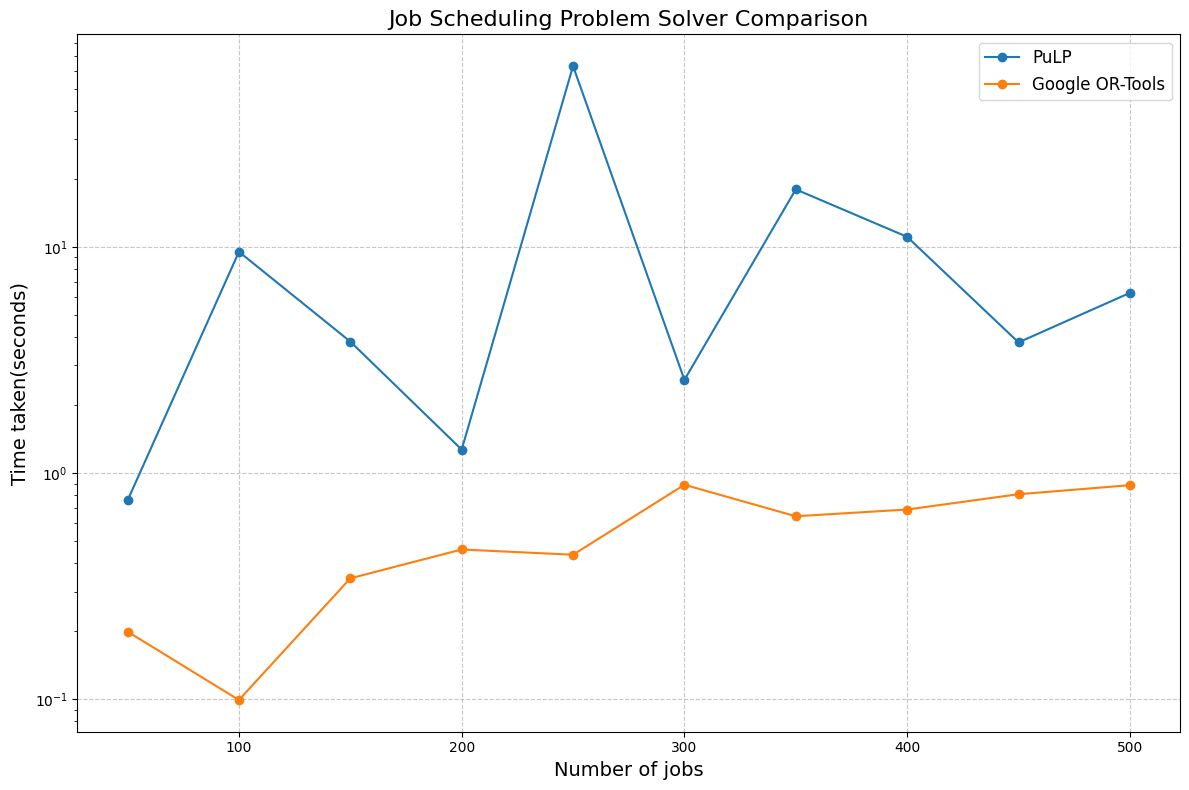

In [6]:
plt.figure(figsize=(12, 8))

plt.plot(n_jobs_list, pulp_times, label="PuLP", marker='o')
plt.plot(n_jobs_list, ortools_times, label="Google OR-Tools", marker='o')

plt.xlabel("Number of jobs",fontsize=14)
plt.ylabel("Time taken(seconds)",fontsize=14)
plt.title("Job Scheduling Problem Solver Comparison",fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale("log")
# plt.xticks(problem_sizes)
plt.tight_layout()
plt.show()

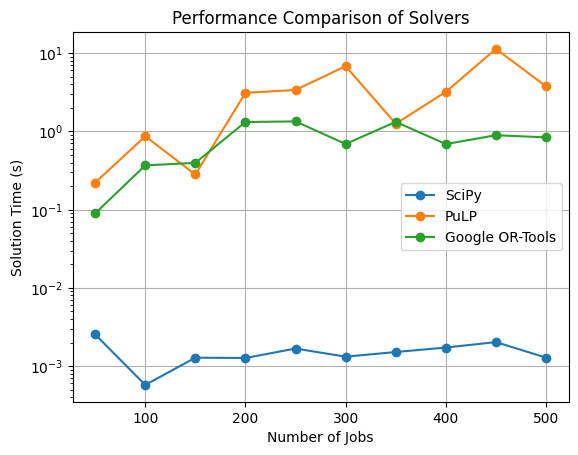

In [ ]:
# Plot
plt.plot(n_jobs_list, scipy_times, label="SciPy", marker='o')


plt.xlabel("Number of Jobs")
plt.ylabel("Solution Time (s)")
plt.title("Performance Comparison of Solvers")
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()


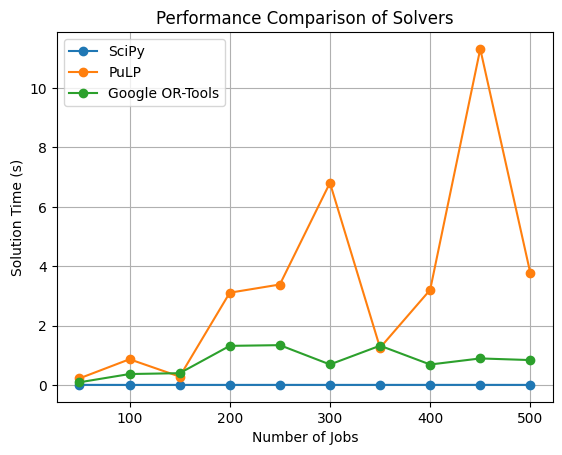

In [ ]:
# Plot
plt.plot(n_jobs_list, scipy_times, label="SciPy", marker='o')
plt.plot(n_jobs_list, pulp_times, label="PuLP", marker='o')
plt.plot(n_jobs_list, ortools_times, label="Google OR-Tools", marker='o')

plt.xlabel("Number of Jobs")
plt.ylabel("Solution Time (s)")
plt.title("Performance Comparison of Solvers")
plt.legend()
# plt.yscale('log')
plt.grid(True)
plt.show()


## 2nd

In [ ]:
!pip install pulp pyomo gekko

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 22.1 MB/s eta 0:00:00


In [ ]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.26.1 which is incompatible.
tensorflow-metadata 1.13.1 requires absl-py<2.0.0,>=0.9, but you have absl-py 2.1.0 which is incompatible

In [8]:
from scipy.optimize import linprog
import numpy as np
import time

def scipy_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility):
    """
    Solves the Parallel Machine Scheduling Problem with eligibility constraints using SciPy.

    Parameters:
        n_jobs (int): Number of jobs.
        n_machines (int): Number of machines.
        processing_times (list): Processing times of each job.
        eligibility (list of lists): List where eligibility[j] contains the jobs machine j can process.

    Returns:
        makespan (float): Approximate makespan value.
        solve_time (float): Time taken to solve the problem.
    """
    start_time = time.time()

    # Decision variables: x[i][j] - binary decision variable if job i is assigned to machine j
    n_vars = n_jobs * n_machines
    c = np.zeros(n_vars)  # Objective is to minimize makespan (set later)

    # Linear programming constraints
    A_eq = []
    b_eq = []

    # Constraint 1: Each job is assigned to exactly one machine
    for i in range(n_jobs):
        row = np.zeros(n_vars)
        for j in range(n_machines):
            row[i * n_machines + j] = 1
        A_eq.append(row)
        b_eq.append(1)

    # Constraint 2: Jobs can only be assigned to eligible machines
    bounds = []
    for i in range(n_jobs):
        for j in range(n_machines):
            if i in eligibility[j]:
                bounds.append((0, 1))  # Binary variable: 0 or 1
            else:
                bounds.append((0, 0))  # Not eligible: must be 0

    # Constraint 3: Makespan constraints
    A_ub = []
    b_ub = []

    for j in range(n_machines):
        row = np.zeros(n_vars)
        for i in range(n_jobs):
            row[i * n_machines + j] = processing_times[i]
        A_ub.append(row)
        b_ub.append(0)  # This will be updated iteratively

    # Solve iteratively to find the makespan (binary integer programming workaround)
    lb, ub = 0, sum(processing_times)
    best_makespan = None

    while lb < ub:
        mid = (lb + ub) // 2

        # Update b_ub with current makespan limit
        for k in range(n_machines):
            b_ub[k] = mid

        # Solve the linear programming relaxation
        res = linprog(
            c,
            A_ub=np.array(A_ub),
            b_ub=np.array(b_ub),
            A_eq=np.array(A_eq),
            b_eq=np.array(b_eq),
            bounds=bounds,
            method='highs'
        )

        # Check if the solution is feasible
        if res.success:
            best_makespan = mid
            ub = mid  # Search for a lower makespan
        else:
            lb = mid + 1  # Increase the lower bound

    solve_time = time.time() - start_time
    return best_makespan, solve_time


In [9]:
import pulp

def pulp_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility):
    start_time = time.time()

    # Create problem
    problem = pulp.LpProblem("Job_Scheduling_with_Eligibility", pulp.LpMinimize)

    # Variables
    x = pulp.LpVariable.dicts("x", [(i, j) for i in range(n_jobs) for j in range(n_machines)],
                              cat="Binary")
    C_max = pulp.LpVariable("C_max", lowBound=0, cat="Continuous")

    # Objective: Minimize makespan
    problem += C_max

    # Constraints: Each job must be assigned to one machine
    for i in range(n_jobs):
        problem += pulp.lpSum(x[(i, j)] for j in range(n_machines)) == 1

    # Constraints: Jobs can only be assigned to eligible machines
    for i in range(n_jobs):
        for j in range(n_machines):
            if i not in eligibility[j]:
                problem += x[(i, j)] == 0

    # Constraints: Machine loads
    for j in range(n_machines):
        problem += pulp.lpSum(processing_times[i] * x[(i, j)] for i in range(n_jobs)) <= C_max

    # Solve
    problem.solve()
    end_time = time.time()

    return pulp.value(C_max), end_time - start_time


In [10]:
from ortools.sat.python import cp_model
import time

def ortools_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility):
    """
    Solves the Parallel Machine Scheduling Problem with eligibility constraints using Google OR-Tools.

    Parameters:
        n_jobs (int): Number of jobs.
        n_machines (int): Number of machines.
        processing_times (list): Processing times of each job.
        eligibility (list of lists): List where eligibility[j] contains the jobs machine j can process.

    Returns:
        makespan (int): Optimal makespan value.
        solve_time (float): Time taken to solve the problem.
    """
    start_time = time.time()

    # Create the CP model
    model = cp_model.CpModel()

    # Variables
    x = {}  # Binary decision variable: x[i, j] = 1 if job i is assigned to machine j
    for i in range(n_jobs):
        for j in range(n_machines):
            x[(i, j)] = model.NewBoolVar(f'x[{i},{j}]')

    # Makespan variable
    C_max = model.NewIntVar(0, sum(processing_times), 'C_max')  # Makespan

    # Constraints: Each job is assigned to exactly one machine
    for i in range(n_jobs):
        model.Add(sum(x[(i, j)] for j in range(n_machines)) == 1)

    # Constraints: Jobs can only be assigned to eligible machines
    for i in range(n_jobs):
        for j in range(n_machines):
            if i not in eligibility[j]:  # If job i is not eligible for machine j
                model.Add(x[(i, j)] == 0)

    # Machine loads and makespan constraints
    machine_loads = []
    for j in range(n_machines):
        load = model.NewIntVar(0, sum(processing_times), f'load_{j}')
        machine_loads.append(load)

        # Calculate the load on machine j
        model.Add(load == sum(processing_times[i] * x[(i, j)] for i in range(n_jobs)))

        # Ensure makespan is at least as large as the load on each machine
        model.Add(C_max >= load)

    # Objective: Minimize makespan
    model.Minimize(C_max)

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)
    end_time = time.time()

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        makespan = solver.Value(C_max)
        solve_time = end_time - start_time
        return makespan, solve_time
    else:
        # print("No solution found!")
        return None, end_time - start_time


In [12]:
!pip install gurobipy

In [13]:
from gurobipy import Model, GRB
import time

def gurobi_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility):
    """
    Solves the Parallel Machine Scheduling Problem with eligibility constraints using Gurobi.

    Parameters:
        n_jobs (int): Number of jobs.
        n_machines (int): Number of machines.
        processing_times (list): Processing times of each job.
        eligibility (list of lists): List where eligibility[j] contains the jobs machine j can process.

    Returns:
        makespan (float): Optimal makespan value.
        solve_time (float): Time taken to solve the problem.
    """
    start_time = time.time()

    # Create a Gurobi model
    model = Model("Parallel_Machine_Scheduling")

    # Decision variables: x[i, j] = 1 if job i is assigned to machine j
    x = model.addVars(n_jobs, n_machines, vtype=GRB.BINARY, name="x")

    # Makespan variable
    C_max = model.addVar(vtype=GRB.CONTINUOUS, name="C_max")

    # Objective: Minimize makespan
    model.setObjective(C_max, GRB.MINIMIZE)

    # Constraint 1: Each job must be assigned to exactly one machine
    for i in range(n_jobs):
        model.addConstr(sum(x[i, j] for j in range(n_machines)) == 1, name=f"Job_Assignment_{i}")

    # Constraint 2: Jobs can only be assigned to eligible machines
    for i in range(n_jobs):
        for j in range(n_machines):
            if i not in eligibility[j]:
                model.addConstr(x[i, j] == 0, name=f"Eligibility_{i}_{j}")

    # Constraint 3: Machine workloads and makespan
    for j in range(n_machines):
        workload = sum(processing_times[i] * x[i, j] for i in range(n_jobs))
        model.addConstr(C_max >= workload, name=f"Makespan_{j}")

    # Solve the model
    model.optimize()

    # Check if the model has a feasible solution
    if model.status == GRB.OPTIMAL:
        makespan = C_max.X
        solve_time = time.time() - start_time
        return makespan, solve_time
    else:
        raise Exception("No optimal solution found")



In [ ]:

# # Plot results
# plt.figure(figsize=(8, 6))
# plt.plot(n_jobs_list, scipy_times, label="SciPy (Heuristic)", marker='o')
# plt.plot(n_jobs_list, pulp_times, label="PuLP (MILP)", marker='o')
# plt.plot(n_jobs_list, ortools_times, label="Google OR-Tools (CP)", marker='o')

# plt.xlabel("Number of Jobs")
# plt.ylabel("Solution Time (s)")
# plt.title("Performance Comparison of Solvers with Eligibility Constraints")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
n_jobs = 10
n_machines = 3
processing_times = [10, 20, 15, 30, 25, 5, 35, 50, 20, 10]
eligibility = [
    [0, 1, 2, 3, 4],  # Machine 0 can process jobs 0, 1, 2, 3, 4
    [5, 6, 7, 8, 9],  # Machine 1 can process jobs 5, 6, 7, 8, 9
    [2, 3, 4, 5, 6]   # Machine 2 can process jobs 2, 3, 4, 5, 6
]

# Solve using Gurobi
makespan, solve_time = gurobi_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility)

print(f"Optimal Makespan: {makespan}")
print(f"Time to Solve: {solve_time:.4f} seconds")

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 28 rows, 31 columns and 78 nonzeros
Model fingerprint: 0xec48f1e0
Variable types: 1 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 110.0000000
Presolve removed 28 rows and 31 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 2: 80 110 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+01, best bound 8.0000

In [ ]:
makespan, solve_time = ortools_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility)

print(f"Optimal Makespan: {makespan}")
print(f"Time to Solve: {solve_time:.4f} seconds")

Optimal Makespan: 80
Time to Solve: 0.0615 seconds


In [ ]:
makespan, solve_time = scipy_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility)

print(f"Optimal Makespan: {makespan}")
print(f"Time to Solve: {solve_time:.4f} seconds")

Optimal Makespan: 80
Time to Solve: 0.0846 seconds


In [ ]:

makespan, solve_time = pulp_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility)

print(f"Optimal Makespan: {makespan}")
print(f"Time to Solve: {solve_time:.4f} seconds")

Optimal Makespan: 80.0
Time to Solve: 0.0311 seconds


In [14]:
import random

def generate_test_case(n_jobs, n_machines, processing_time_range):
    """
    Generates a test case for the parallel machine scheduling problem.

    Parameters:
        n_jobs (int): Number of jobs.
        n_machines (int): Number of machines.
        processing_time_range (tuple): Min and max processing times for jobs (inclusive).

    Returns:
        tuple: (processing_times, eligibility) where:
            - processing_times (list): List of processing times for each job.
            - eligibility (list of lists): Eligibility constraints for each machine.
    """
    # Generate random processing times for each job
    processing_times = [random.randint(processing_time_range[0], processing_time_range[1]) for _ in range(n_jobs)]

    # Ensure every job is assigned to at least one machine
    eligibility = [[] for _ in range(n_machines)]
    for i in range(n_jobs):
        # Randomly assign job `i` to at least one machine
        assigned_machines = random.sample(range(n_machines), random.randint(1, n_machines))
        for machine in assigned_machines:
            eligibility[machine].append(i)

    return processing_times, eligibility

In [15]:
# Scaling analysis
n_jobs_list = range(1, 31, 5)
processing_time_range = (5, 50)
n_machines = 5
scipy_times = []
pulp_times = []
ortools_times = []
gurobi_times = []
s1=[]
s2=[]
s3=[]
s4=[]

for n_jobs in n_jobs_list:
    processing_times, eligibility = generate_test_case(n_jobs, n_machines, processing_time_range)
    print(n_jobs)

    # # Solve with SciPy (Heuristic)
    si, scipy_time = scipy_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility)
    scipy_times.append(scipy_time)
    s3.append(si)

    # Solve with PuLP
    so, pulp_time = pulp_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility)
    pulp_times.append(pulp_time)
    s1.append(so)


    # Solve with Google OR-Tools
    sp, ortools_time = ortools_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility)
    ortools_times.append(ortools_time)
    s2.append(sp)

    # Solve using Gurobi
    sa, gurobi_time = gurobi_job_scheduling_with_eligibility(n_jobs, n_machines, processing_times, eligibility)
    gurobi_times.append(gurobi_time)
    s4.append(sa)




1
Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 8 rows, 6 columns and 17 nonzeros
Model fingerprint: 0x684f4c71
Variable types: 1 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 8 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 50 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+01, best bound 5.000000000000e+01, gap 0.0000%
6
Gurobi Optimizer version 12.

In [ ]:
s1

[6.0, 34.0, 79.0, 86.0, 111.0, 140.0]

In [ ]:
s2

[6, 34, 79, 86, 111, 140]

In [ ]:
s3

[2, 21, 65, 85, 110, 140]

In [ ]:
s4

[6.0, 34.0, 79.0, 86.0, 111.0, 140.0]

In [ ]:
import matplotlib.pyplot as plt

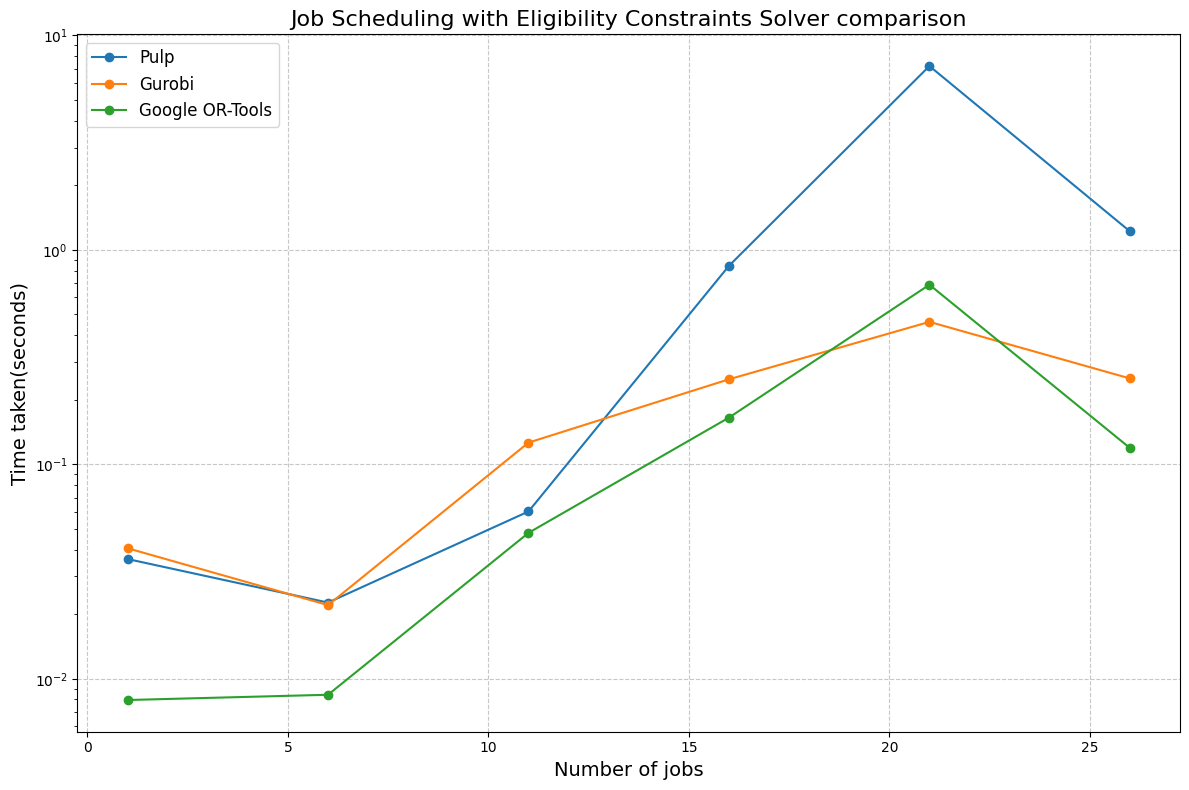

In [16]:
# Plot results
plt.figure(figsize=(12, 8))
# plt.plot(n_jobs_list, scipy_times, label="SciPy", marker='o')
plt.plot(n_jobs_list, pulp_times, label="Pulp", marker='o')
plt.plot(n_jobs_list, gurobi_times, label="Gurobi", marker='o')
plt.plot(n_jobs_list, ortools_times, label="Google OR-Tools", marker='o')

plt.xlabel("Number of jobs",fontsize=14)
plt.ylabel("Time taken(seconds)",fontsize=14)
plt.title("Job Scheduling with Eligibility Constraints Solver comparison",fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.yscale("log")
# plt.show()
plt.tight_layout()
plt.show()
# plt.figure(figsize=(12, 8


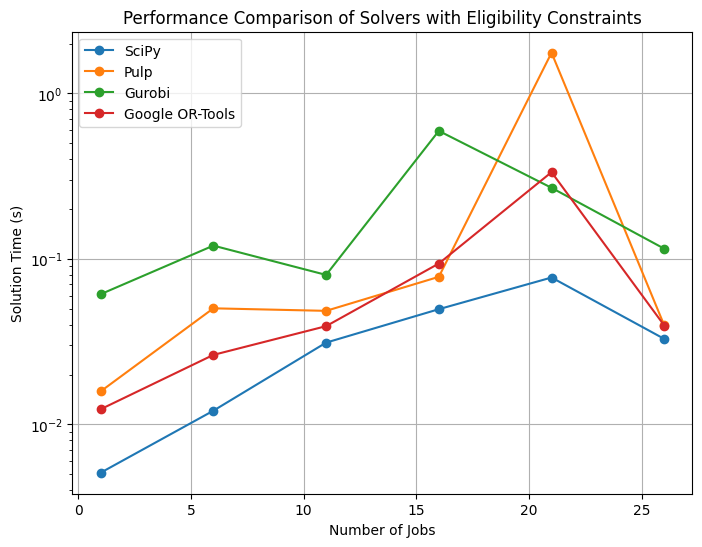

In [ ]:
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(n_jobs_list, scipy_times, label="SciPy", marker='o')
plt.plot(n_jobs_list, pulp_times, label="Pulp", marker='o')
plt.plot(n_jobs_list, gurobi_times, label="Gurobi", marker='o')
plt.plot(n_jobs_list, ortools_times, label="Google OR-Tools", marker='o')

plt.xlabel("Number of Jobs")
plt.ylabel("Solution Time (s)")
plt.title("Performance Comparison of Solvers with Eligibility Constraints")
plt.legend()
plt.yscale('log')  # Log scale if execution times vary widely
plt.grid(True)
plt.show()

## 3

In [ ]:
from gurobipy import Model, GRB
from ortools.sat.python import cp_model
from pulp import LpProblem, LpMinimize, LpVariable, lpSum
import time
import random

# -------------------- Gurobi Solver --------------------
def gurobi_solve_with_subtasks(n_jobs, n_machines, subtask_processing_times, subtask_eligibility):
    start_time = time.time()

    model = Model("Job_Scheduling_with_Subtasks")

    # Decision variables: x[j, s, m] = 1 if subtask s of job j is assigned to machine m
    x = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            for m in range(n_machines):
                x[j, s, m] = model.addVar(vtype=GRB.BINARY, name=f"x_{j}_{s}_{m}")

    # Variables for start times of each subtask
    start_time_vars = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            start_time_vars[j, s] = model.addVar(vtype=GRB.CONTINUOUS, name=f"start_{j}_{s}")

    # Makespan variable
    makespan = model.addVar(vtype=GRB.CONTINUOUS, name="makespan")

    # Objective: Minimize makespan
    model.setObjective(makespan, GRB.MINIMIZE)

    # Constraints
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Ensure each subtask is assigned to exactly one machine
            model.addConstr(sum(x[j, s, m] for m in range(n_machines)) == 1, name=f"assign_{j}_{s}")

            # Eligibility constraint
            for m in range(n_machines):
                if m not in subtask_eligibility[j][s]:
                    model.addConstr(x[j, s, m] == 0, name=f"eligibility_{j}_{s}_{m}")

    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Start time + processing time constraint
            model.addConstr(
                start_time_vars[j, s] + sum(subtask_processing_times[j][s] * x[j, s, m] for m in range(n_machines)) <= makespan,
                name=f"makespan_{j}_{s}"
            )
            # Sequential order constraint for subtasks
            if s > 0:
                model.addConstr(
                    start_time_vars[j, s] >= start_time_vars[j, s - 1] + sum(subtask_processing_times[j][s - 1] * x[j, s - 1, m] for m in range(n_machines)),
                    name=f"order_{j}_{s}"
                )

    # Solve the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        solve_time = time.time() - start_time
        return makespan.X, solve_time
    else:
        raise Exception("No optimal solution found")

# -------------------- Google OR-Tools Solver --------------------
def ortools_solve_with_subtasks(n_jobs, n_machines, subtask_processing_times, subtask_eligibility):
    start_time = time.time()

    model = cp_model.CpModel()

    # Decision variables: x[j, s, m] = 1 if subtask s of job j is assigned to machine m
    x = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            for m in range(n_machines):
                x[j, s, m] = model.NewBoolVar(f"x_{j}_{s}_{m}")

    # Start time variables
    start_time_vars = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            start_time_vars[j, s] = model.NewIntVar(0, sum(map(sum, subtask_processing_times)), f"start_{j}_{s}")

    # Makespan variable
    makespan = model.NewIntVar(0, sum(map(sum, subtask_processing_times)), "makespan")

    # Objective: Minimize makespan
    model.Minimize(makespan)

    # Constraints
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Ensure each subtask is assigned to exactly one machine
            model.Add(sum(x[j, s, m] for m in range(n_machines)) == 1)

            # Eligibility constraint
            for m in range(n_machines):
                if m not in subtask_eligibility[j][s]:
                    model.Add(x[j, s, m] == 0)

    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Start time + processing time constraint
            model.Add(start_time_vars[j, s] + sum(subtask_processing_times[j][s] * x[j, s, m] for m in range(n_machines)) <= makespan)

            # Sequential order constraint for subtasks
            if s > 0:
                model.Add(
                    start_time_vars[j, s] >= start_time_vars[j, s - 1] + sum(subtask_processing_times[j][s - 1] * x[j, s - 1, m] for m in range(n_machines))
                )

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL:
        solve_time = time.time() - start_time
        return solver.ObjectiveValue(), solve_time
    else:
        raise Exception("No optimal solution found")

# -------------------- PuLP Solver --------------------
def pulp_solve_with_subtasks(n_jobs, n_machines, subtask_processing_times, subtask_eligibility):
    start_time = time.time()

    problem = LpProblem("Job_Scheduling_with_Subtasks", LpMinimize)

    # Decision variables: x[j, s, m] = 1 if subtask s of job j is assigned to machine m
    x = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            for m in range(n_machines):
                x[j, s, m] = LpVariable(f"x_{j}_{s}_{m}", cat="Binary")

    # Start time variables
    start_time_vars = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            start_time_vars[j, s] = LpVariable(f"start_{j}_{s}", lowBound=0, cat="Continuous")

    # Makespan variable
    makespan = LpVariable("makespan", lowBound=0, cat="Continuous")

    # Objective: Minimize makespan
    problem += makespan

    # Constraints
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Ensure each subtask is assigned to exactly one machine
            problem += lpSum(x[j, s, m] for m in range(n_machines)) == 1

            # Eligibility constraint
            for m in range(n_machines):
                if m not in subtask_eligibility[j][s]:
                    problem += x[j, s, m] == 0

    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Start time + processing time constraint
            problem += start_time_vars[j, s] + lpSum(subtask_processing_times[j][s] * x[j, s, m] for m in range(n_machines)) <= makespan

            # Sequential order constraint for subtasks
            if s > 0:
                problem += start_time_vars[j, s] >= start_time_vars[j, s - 1] + lpSum(subtask_processing_times[j][s - 1] * x[j, s - 1, m] for m in range(n_machines))

    # Solve the model
    problem.solve()

    if problem.status == 1:  # Optimal
        solve_time = time.time() - start_time
        print("PuLP Solution:")
        for j in range(n_jobs):
            for s in range(len(subtask_processing_times[j])):
                for m in range(n_machines):
                    if x[j, s, m].varValue > 0.5:
                        start = start_time_vars[j, s].varValue
                        print(f"  Job {j} Subtask {s} assigned to Machine {m} with start time {start:.2f}")
        print(f"  Makespan: {makespan.varValue:.2f}")
        return makespan.varValue, solve_time

In [ ]:
import random

def generate_test_case(num_jobs, num_machines, max_subtasks_per_job, max_processing_time):

    subtask_processing_times = []
    subtask_eligibility = []

    for job in range(num_jobs):
        num_subtasks = random.randint(1, max_subtasks_per_job)  # Random number of subtasks for this job
        job_processing_times = []
        job_eligibility = []

        for subtask in range(num_subtasks):
            # Random processing times for each machine
            processing_times = [
                random.randint(1, max_processing_time) if random.random() > 0.3 else 0
                for _ in range(num_machines)
            ]
            job_processing_times.append(processing_times)

            # Random eligibility for each machine
            # Random eligibility for each machine with at least one machine always eligible
            eligible_machines = random.sample(range(num_machines), random.randint(1, num_machines))
            eligibility = [1 if m in eligible_machines else 0 for m in range(num_machines)]
            if not any(eligibility):
                eligibility[random.randint(0, num_machines - 1)] = 1
            job_eligibility.append(eligibility)

        subtask_processing_times.append(job_processing_times)
        subtask_eligibility.append(job_eligibility)

    return subtask_processing_times, subtask_eligibility

n_machines = 3
max_subtasks_per_job = 4
max_processing_time = 20

In [ ]:
# -------------------- Example Usage --------------------
n_jobs = 3
n_machines = 3
subtask_processing_times = [[10, 20], [15, 10], [30, 25]]  # Processing times for each subtask of each job
subtask_eligibility = [
    [[0, 1], [1, 2]],  # Job 0: Subtask 0 can be on machines 0 and 1, Subtask 1 can be on machines 1 and 2
    [[0, 2], [1, 2]],  # Job 1: Subtask 0 can be on machines 0 and 2, Subtask 1 can be on machines 1 and 2
    [[1, 2], [0, 2]]   # Job 2: Subtask 0 can be on machines 1 and 2, Subtask 1 can be on machines 0 and 2
]

# Test the Gurobi solver
try:
    gurobi_makespan, gurobi_solve_time = gurobi_solve_with_subtasks(
        n_jobs, n_machines, subtask_processing_times, subtask_eligibility
    )
    print(f"Gurobi: Makespan = {gurobi_makespan}, Time = {gurobi_solve_time:.4f} seconds")
except Exception as e:
    print(f"Gurobi solver failed: {e}")

# Test the OR-Tools solver
try:
    ortools_makespan, ortools_solve_time = ortools_solve_with_subtasks(
        n_jobs, n_machines, subtask_processing_times, subtask_eligibility
    )
    print(f"OR-Tools: Makespan = {ortools_makespan}, Time = {ortools_solve_time:.4f} seconds")
except Exception as e:
    print(f"OR-Tools solver failed: {e}")

# Test the PuLP solver
try:
    pulp_makespan, pulp_solve_time = pulp_solve_with_subtasks(
        n_jobs, n_machines, subtask_processing_times, subtask_eligibility
    )
    print(f"PuLP: Makespan = {pulp_makespan}, Time = {pulp_solve_time:.4f} seconds")
except Exception as e:
    print(f"PuLP solver failed: {e}")


Gurobi solver failed: name 'Model' is not defined
OR-Tools: Makespan = 55.0, Time = 0.0046 seconds
PuLP Solution:
  Job 0 Subtask 0 assigned to Machine 1 with start time 0.00
  Job 0 Subtask 1 assigned to Machine 1 with start time 10.00
  Job 1 Subtask 0 assigned to Machine 0 with start time 0.00
  Job 1 Subtask 1 assigned to Machine 2 with start time 15.00
  Job 2 Subtask 0 assigned to Machine 2 with start time 0.00
  Job 2 Subtask 1 assigned to Machine 0 with start time 30.00
  Makespan: 55.00
PuLP: Makespan = 55.0, Time = 0.0160 seconds


<ipython-input-16-f384271a8069>:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[m].legend()


IndexError: list index out of range

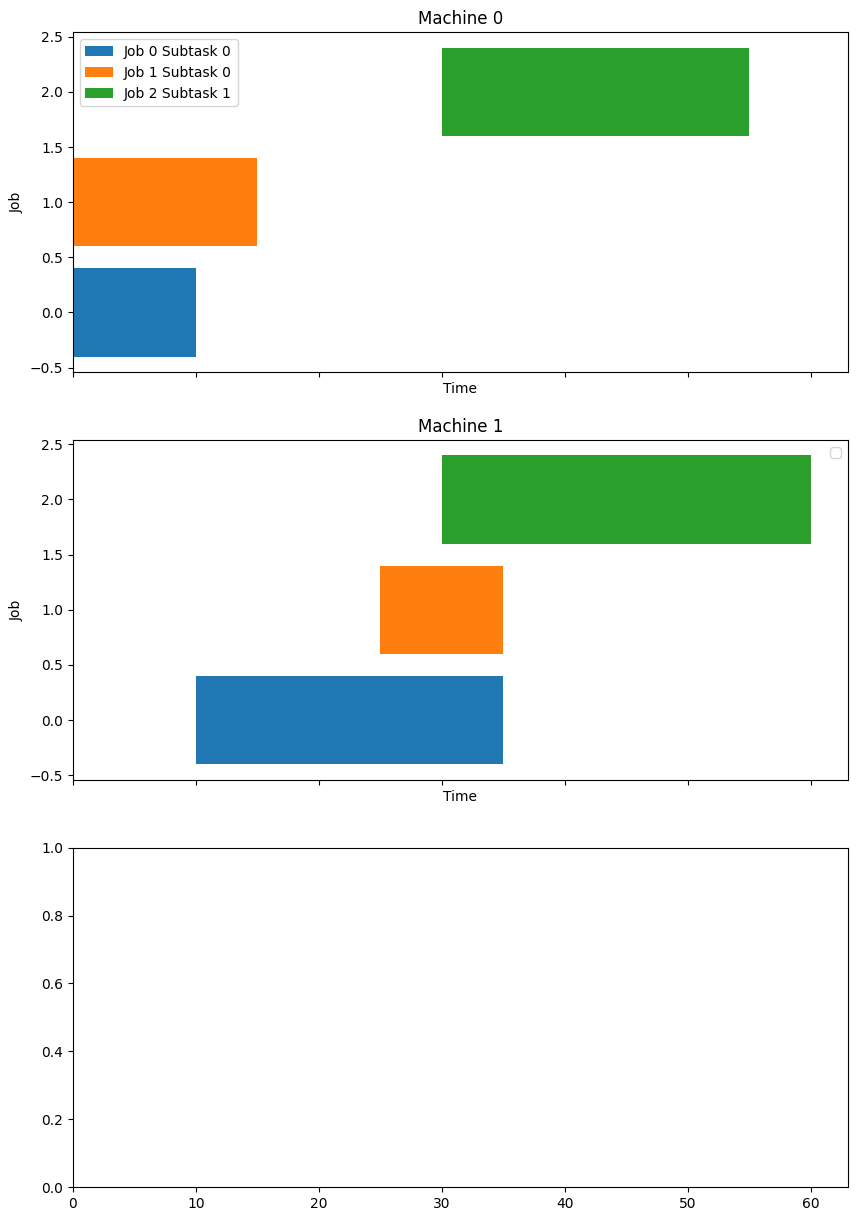

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# -------------------- Plotting Function --------------------
def plot_job_schedule(n_jobs, n_machines, subtask_processing_times, subtask_eligibility, start_times):
    """
    Plots the job schedule on each machine, showing job subtasks and their start times.

    Arguments:
    - n_jobs: Number of jobs
    - n_machines: Number of machines
    - subtask_processing_times: List of processing times for each subtask of each job
    - subtask_eligibility: Eligibility of machines for each subtask
    - start_times: Start times for each subtask (from the solver output)
    """
    # Colors for the jobs
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Create a plot for each machine
    fig, ax = plt.subplots(n_machines, 1, figsize=(10, 5 * n_machines), sharex=True)

    # If only one machine, ax will be a single axis, so make it iterable
    if n_machines == 1:
        ax = [ax]

    # Iterate over each machine and plot the schedule
    for m in range(n_machines):
        for j in range(n_jobs):
            for s in range(len(subtask_processing_times[j])):
                # Check if subtask s of job j is assigned to machine m
                if m in subtask_eligibility[j][s]:
                    start_time = start_times[j][s][m]  # Start time for this subtask on this machine
                    end_time = start_time + subtask_processing_times[j][s]

                    # Plot the job subtask as a horizontal bar
                    ax[m].barh(y=j, left=start_time, width=subtask_processing_times[j][s], height=0.8,
                               color=colors[j % len(colors)], label=f"Job {j} Subtask {s}" if m == 0 else "")

        ax[m].set_xlabel("Time")
        ax[m].set_ylabel("Job")
        ax[m].set_title(f"Machine {m}")
        ax[m].legend()

    plt.tight_layout()
    plt.show()

# -------------------- Example Data --------------------

# Number of jobs and machines
n_jobs = 3
n_machines = 3

# Processing times for each subtask of each job
subtask_processing_times = [[10, 20], [15, 10], [30, 25]]

# Eligibility for each subtask of each job on machines
subtask_eligibility = [
    [[0, 1], [1, 2]],  # Job 0: Subtask 0 can be on machines 0 and 1, Subtask 1 can be on machines 1 and 2
    [[0, 2], [1, 2]],  # Job 1: Subtask 0 can be on machines 0 and 2, Subtask 1 can be on machines 1 and 2
    [[1, 2], [0, 2]]   # Job 2: Subtask 0 can be on machines 1 and 2, Subtask 1 can be on machines 0 and 2
]

# Hardcoded start times from the problem statement
# Format: start_times[j][s][m] where j=job, s=subtask, m=machine
start_times = [
    [[0, 10], [10, 15]],  # Job 0, Subtask 0 starts at 0 on Machine 0, Subtask 1 starts at 10 on Machine 1
    [[0, 15], [15, 25]],  # Job 1, Subtask 0 starts at 0 on Machine 0, Subtask 1 starts at 15 on Machine 2
    [[10, 30], [30, 50]]  # Job 2, Subtask 0 starts at 10 on Machine 1, Subtask 1 starts at 30 on Machine 0
]

# Call the plot function
plot_job_schedule(n_jobs, n_machines, subtask_processing_times, subtask_eligibility, start_times)


<ipython-input-17-df194762c60a>:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[m].legend()


IndexError: list index out of range

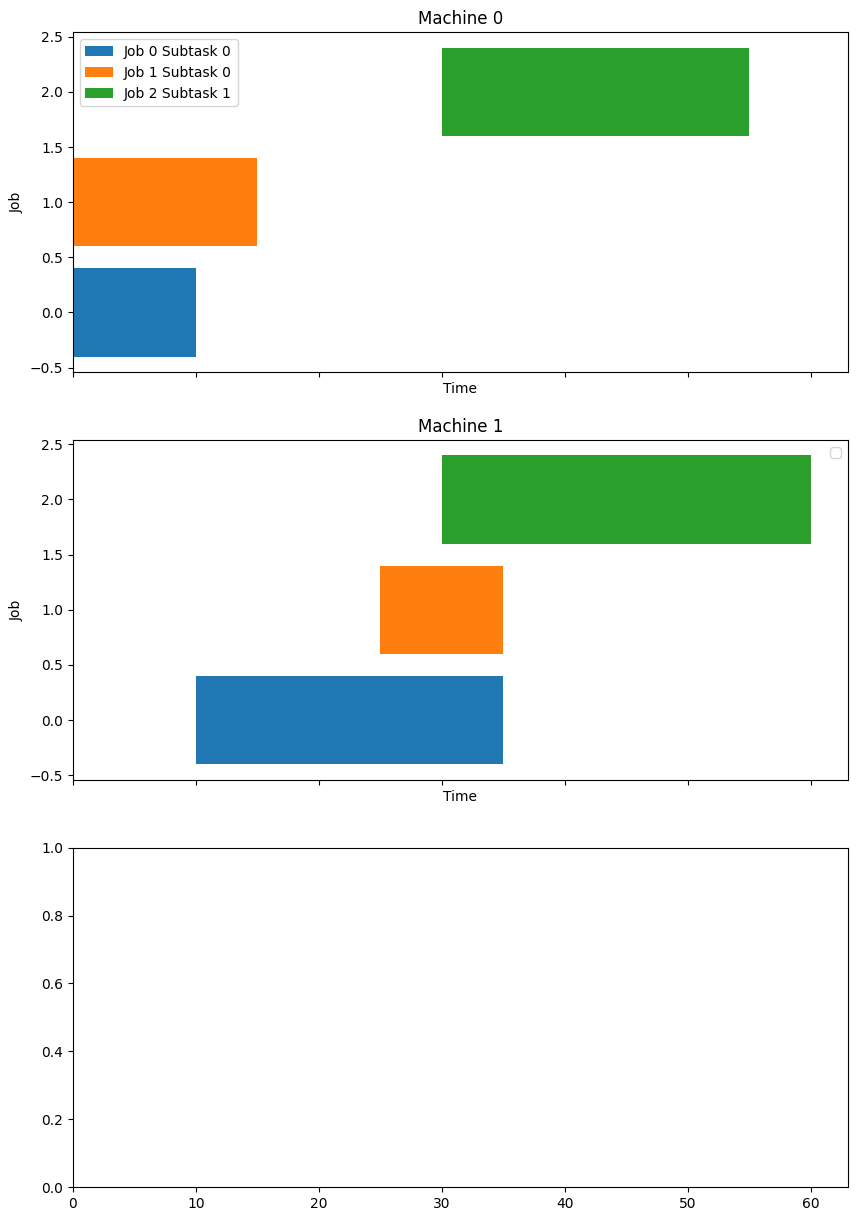

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# -------------------- Plotting Function --------------------
def plot_gantt_chart(n_jobs, n_machines, subtask_processing_times, subtask_eligibility, start_times):
    """
    Plots the job schedule on each machine as a Gantt chart, showing job subtasks and their start times.

    Arguments:
    - n_jobs: Number of jobs
    - n_machines: Number of machines
    - subtask_processing_times: List of processing times for each subtask of each job
    - subtask_eligibility: Eligibility of machines for each subtask
    - start_times: Start times for each subtask (from the solver output)
    """
    # Colors for the jobs (we use distinct colors for each job)
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Create a plot for each machine
    fig, ax = plt.subplots(n_machines, 1, figsize=(10, 5 * n_machines), sharex=True)

    # If only one machine, ax will be a single axis, so make it iterable
    if n_machines == 1:
        ax = [ax]

    # Iterate over each machine and plot the schedule
    for m in range(n_machines):
        for j in range(n_jobs):
            for s in range(len(subtask_processing_times[j])):
                # Check if subtask s of job j is assigned to machine m
                if m in subtask_eligibility[j][s]:
                    start_time = start_times[j][s][m]  # Start time for this subtask on this machine
                    end_time = start_time + subtask_processing_times[j][s]

                    # Plot the job subtask as a horizontal bar
                    ax[m].barh(y=j, left=start_time, width=subtask_processing_times[j][s], height=0.8,
                               color=colors[j % len(colors)], label=f"Job {j} Subtask {s}" if m == 0 else "")

        ax[m].set_xlabel("Time")
        ax[m].set_ylabel("Job")
        ax[m].set_title(f"Machine {m}")
        ax[m].legend()

    plt.tight_layout()
    plt.show()

# -------------------- Example Data --------------------

# Number of jobs and machines
n_jobs = 3
n_machines = 3

# Processing times for each subtask of each job
subtask_processing_times = [[10, 20], [15, 10], [30, 25]]

# Eligibility for each subtask of each job on machines
subtask_eligibility = [
    [[0, 1], [1, 2]],  # Job 0: Subtask 0 can be on machines 0 and 1, Subtask 1 can be on machines 1 and 2
    [[0, 2], [1, 2]],  # Job 1: Subtask 0 can be on machines 0 and 2, Subtask 1 can be on machines 1 and 2
    [[1, 2], [0, 2]]   # Job 2: Subtask 0 can be on machines 1 and 2, Subtask 1 can be on machines 0 and 2
]

# Hardcoded start times from the problem statement
# Format: start_times[j][s][m] where j=job, s=subtask, m=machine
start_times = [
    [[0, 10], [10, 15]],  # Job 0, Subtask 0 starts at 0 on Machine 0, Subtask 1 starts at 10 on Machine 1
    [[0, 15], [15, 25]],  # Job 1, Subtask 0 starts at 0 on Machine 0, Subtask 1 starts at 15 on Machine 2
    [[10, 30], [30, 50]]  # Job 2, Subtask 0 starts at 10 on Machine 1, Subtask 1 starts at 30 on Machine 0
]

# Call the plot function to generate the Gantt chart
plot_gantt_chart(n_jobs, n_machines, subtask_processing_times, subtask_eligibility, start_times)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_job_schedule(n_jobs, n_machines, subtask_processing_times, subtask_eligibility, solver_type="Gurobi", solver_output=None):
    """
    Plots the job schedule on each machine, showing job subtasks and their start times.

    Arguments:
    - n_jobs: Number of jobs
    - n_machines: Number of machines
    - subtask_processing_times: List of processing times for each subtask of each job
    - subtask_eligibility: Eligibility of machines for each subtask
    - solver_type: Type of solver used (Gurobi, OR-Tools, or PuLP)
    - solver_output: Output from the solver containing the job schedule
    """
    # Colors for the jobs
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Create a plot for each machine
    fig, ax = plt.subplots(n_machines, 1, figsize=(10, 5 * n_machines), sharex=True)

    # If only one machine, ax will be a single axis, so make it iterable
    if n_machines == 1:
        ax = [ax]

    # Iterate over each machine and plot the schedule
    for m in range(n_machines):
        for j in range(n_jobs):
            for s in range(len(subtask_processing_times[j])):
                if solver_type == "Gurobi":
                    if solver_output[0][j, s, m].X > 0.5:  # For Gurobi
                        start_time = solver_output[1][j, s].X
                elif solver_type == "OR-Tools":
                    if solver_output[0].BooleanValue(solver_output[1][j, s, m]):  # For OR-Tools
                        start_time = solver_output[2][j, s].Value()
                elif solver_type == "PuLP":
                    if solver_output[0][j, s, m].varValue > 0.5:  # For PuLP
                        start_time = solver_output[1][j, s].varValue

                end_time = start_time + subtask_processing_times[j][s]

                # Plot the job subtask as a horizontal bar
                ax[m].barh(y=j, left=start_time, width=subtask_processing_times[j][s], height=0.8,
                           color=colors[j % len(colors)], label=f"Job {j} Subtask {s}" if m == 0 else "")

        ax[m].set_xlabel("Time")
        ax[m].set_ylabel("Job")
        ax[m].set_title(f"Machine {m}")
        ax[m].legend()

    plt.tight_layout()
    plt.show()

# Sample solver output format for testing
# solver_output = (x_values, start_time_values, makespan_values)

# Test the plot function with a solver output (e.g., from Gurobi)
try:
    gurobi_makespan, gurobi_solve_time = gurobi_solve_with_subtasks(n_jobs, n_machines, subtask_processing_times, subtask_eligibility)
    print(f"Gurobi: Makespan = {gurobi_makespan}, Time = {gurobi_solve_time:.4f} seconds")
    plot_job_schedule(n_jobs, n_machines, subtask_processing_times, subtask_eligibility, solver_type="Gurobi", solver_output=gurobi_output)
except Exception as e:
    print(f"Gurobi solver failed: {e}")


Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 21 rows, 25 columns and 69 nonzeros
Model fingerprint: 0x8c3fad3a
Variable types: 7 continuous, 18 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 55.0000000
Presolve removed 21 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 55 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.500000000000e+01, best bound 5.500000000

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 56 rows, 61 columns and 186 nonzeros
Model fingerprint: 0xaf3fcb41
Variable types: 16 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 13.0000000
Presolve removed 56 rows and 61 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 13 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.300000000000e+01, best bound 1.300000000000e+01, gap 0.0000%
Gurobi: Makespan = 13.0, Time = 0.0255 seconds


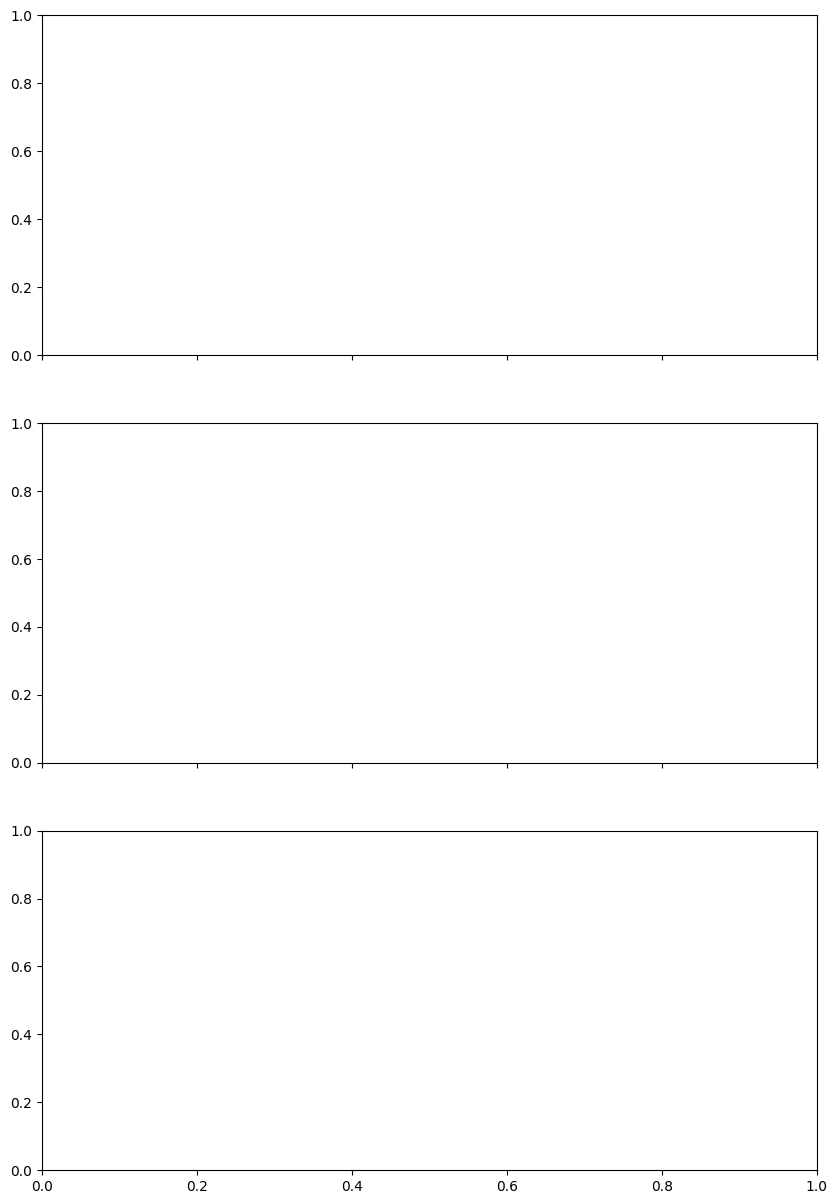

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time
from gurobipy import Model, GRB
from ortools.sat.python import cp_model
from pulp import LpProblem, LpMinimize, LpVariable, lpSum

# -------------------- Gurobi Solver --------------------
def gurobi_solve_with_subtasks(n_jobs, n_machines, subtask_processing_times, subtask_eligibility):
    start_time = time.time()

    model = Model("Job_Scheduling_with_Subtasks")

    # Decision variables: x[j, s, m] = 1 if subtask s of job j is assigned to machine m
    x = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            for m in range(n_machines):
                x[j, s, m] = model.addVar(vtype=GRB.BINARY, name=f"x_{j}_{s}_{m}")

    # Variables for start times of each subtask
    start_time_vars = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            start_time_vars[j, s] = model.addVar(vtype=GRB.CONTINUOUS, name=f"start_{j}_{s}")

    # Makespan variable
    makespan = model.addVar(vtype=GRB.CONTINUOUS, name="makespan")

    # Objective: Minimize makespan
    model.setObjective(makespan, GRB.MINIMIZE)

    # Constraints
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Ensure each subtask is assigned to exactly one machine
            model.addConstr(sum(x[j, s, m] for m in range(n_machines)) == 1, name=f"assign_{j}_{s}")

            # Eligibility constraint
            for m in range(n_machines):
                if m not in subtask_eligibility[j][s]:
                    model.addConstr(x[j, s, m] == 0, name=f"eligibility_{j}_{s}_{m}")

    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Start time + processing time constraint
            model.addConstr(
                start_time_vars[j, s] + sum(subtask_processing_times[j][s] * x[j, s, m] for m in range(n_machines)) <= makespan,
                name=f"makespan_{j}_{s}"
            )
            # Sequential order constraint for subtasks
            if s > 0:
                model.addConstr(
                    start_time_vars[j, s] >= start_time_vars[j, s - 1] + sum(subtask_processing_times[j][s - 1] * x[j, s - 1, m] for m in range(n_machines)),
                    name=f"order_{j}_{s}"
                )

    # Solve the model
    model.optimize()

    if model.status == GRB.OPTIMAL:
        solve_time = time.time() - start_time
        return makespan.X, solve_time, x, start_time_vars
    else:
        raise Exception("No optimal solution found")

# -------------------- Google OR-Tools Solver --------------------
def ortools_solve_with_subtasks(n_jobs, n_machines, subtask_processing_times, subtask_eligibility):
    start_time = time.time()

    model = cp_model.CpModel()

    # Decision variables: x[j, s, m] = 1 if subtask s of job j is assigned to machine m
    x = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            for m in range(n_machines):
                x[j, s, m] = model.NewBoolVar(f"x_{j}_{s}_{m}")

    # Start time variables
    start_time_vars = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            start_time_vars[j, s] = model.NewIntVar(0, sum(map(sum, subtask_processing_times)), f"start_{j}_{s}")

    # Makespan variable
    makespan = model.NewIntVar(0, sum(map(sum, subtask_processing_times)), "makespan")

    # Objective: Minimize makespan
    model.Minimize(makespan)

    # Constraints
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Ensure each subtask is assigned to exactly one machine
            model.Add(sum(x[j, s, m] for m in range(n_machines)) == 1)

            # Eligibility constraint
            for m in range(n_machines):
                if m not in subtask_eligibility[j][s]:
                    model.Add(x[j, s, m] == 0)

    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Start time + processing time constraint
            model.Add(start_time_vars[j, s] + sum(subtask_processing_times[j][s] * x[j, s, m] for m in range(n_machines)) <= makespan)

            # Sequential order constraint for subtasks
            if s > 0:
                model.Add(
                    start_time_vars[j, s] >= start_time_vars[j, s - 1] + sum(subtask_processing_times[j][s - 1] * x[j, s - 1, m] for m in range(n_machines))
                )

    # Solve the model
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL:
        solve_time = time.time() - start_time
        return solver.ObjectiveValue(), solve_time, x, start_time_vars
    else:
        raise Exception("No optimal solution found")

# -------------------- PuLP Solver --------------------
def pulp_solve_with_subtasks(n_jobs, n_machines, subtask_processing_times, subtask_eligibility):
    start_time = time.time()

    problem = LpProblem("Job_Scheduling_with_Subtasks", LpMinimize)

    # Decision variables: x[j, s, m] = 1 if subtask s of job j is assigned to machine m
    x = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            for m in range(n_machines):
                x[j, s, m] = LpVariable(f"x_{j}_{s}_{m}", cat="Binary")

    # Start time variables
    start_time_vars = {}
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            start_time_vars[j, s] = LpVariable(f"start_{j}_{s}", lowBound=0, cat="Continuous")

    # Makespan variable
    makespan = LpVariable("makespan", lowBound=0, cat="Continuous")

    # Objective: Minimize makespan
    problem += makespan

    # Constraints
    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Ensure each subtask is assigned to exactly one machine
            problem += lpSum(x[j, s, m] for m in range(n_machines)) == 1

            # Eligibility constraint
            for m in range(n_machines):
                if m not in subtask_eligibility[j][s]:
                    problem += x[j, s, m] == 0

    for j in range(n_jobs):
        for s in range(len(subtask_processing_times[j])):
            # Start time + processing time constraint
            problem += start_time_vars[j, s] + lpSum(subtask_processing_times[j][s] * x[j, s, m] for m in range(n_machines)) <= makespan

            # Sequential order constraint for subtasks
            if s > 0:
                problem += start_time_vars[j, s] >= start_time_vars[j, s - 1] + lpSum(subtask_processing_times[j][s - 1] * x[j, s - 1, m] for m in range(n_machines))

    # Solve the model
    problem.solve()

    if problem.status == 1:  # Optimal
        solve_time = time.time() - start_time
        return makespan.varValue, solve_time, x, start_time_vars
    else:
        raise Exception("No optimal solution found")

# -------------------- Plotting Function --------------------
def plot_job_schedule(n_jobs, n_machines, subtask_processing_times, subtask_eligibility, solver_type="Gurobi", solver_output=None):
    """
    Plots the job schedule on each machine, showing job subtasks and their start times.

    Arguments:
    - n_jobs: Number of jobs
    - n_machines: Number of machines
    - subtask_processing_times: List of processing times for each subtask of each job
    - subtask_eligibility: Eligibility of machines for each subtask
    - solver_type: Type of solver used (Gurobi, OR-Tools, or PuLP)
    - solver_output: Output from the solver containing the job schedule
    """
    # Colors for the jobs
    colors = list(mcolors.TABLEAU_COLORS.values())

    # Create a plot for each machine
    fig, ax = plt.subplots(n_machines, 1, figsize=(10, 5 * n_machines), sharex=True)

    # If only one machine, ax will be a single axis, so make it iterable
    if n_machines == 1:
        ax = [ax]

    # Iterate over each machine and plot the schedule
    for m in range(n_machines):
        for j in range(n_jobs):
            for s in range(len(subtask_processing_times[j])):
                if solver_type == "Gurobi":
                    if solver_output[2][j, s, m].X > 0.5:  # For Gurobi
                        start_time = solver_output[3][j, s].X
                elif solver_type == "OR-Tools":
                    if solver_output[2].BooleanValue(solver_output[3][j, s, m]):  # For OR-Tools
                        start_time = solver_output[3][j, s].Value()
                elif solver_type == "PuLP":
                    if solver_output[2][j, s, m].varValue > 0.5:  # For PuLP
                        start_time = solver_output[3][j, s].varValue

                end_time = start_time + subtask_processing_times[j][s]

                # Plot the job subtask as a horizontal bar
                ax[m].barh(y=j, left=start_time, width=subtask_processing_times[j][s], height=0.8,
                           color=colors[j % len(colors)], label=f"Job {j} Subtask {s}" if m == 0 else "")

        ax[m].set_xlabel("Time")
        ax[m].set_ylabel("Job")
        ax[m].set_title(f"Machine {m}")
        ax[m].legend()

    plt.tight_layout()
    plt.show()

# -------------------- Example Usage --------------------
n_jobs = 5
n_machines = 3
subtask_processing_times = [[3, 2, 5], [4, 3, 6], [2, 4, 3], [6, 4, 3], [5, 3, 4]]  # Example
subtask_eligibility = [[[0, 1], [1, 2], [2, 0]], [[1, 2], [0, 2], [0, 1]], [[0, 2], [2, 1], [1, 0]],
                       [[1, 2], [0, 1], [2, 1]], [[0, 1], [1, 0], [2, 2]]]  # Eligibility matrix

# Call the solver and plot
try:
    makespan, solve_time, x, start_time_vars = gurobi_solve_with_subtasks(n_jobs, n_machines, subtask_processing_times, subtask_eligibility)
    print(f"Gurobi: Makespan = {makespan}, Time = {solve_time:.4f} seconds")
    plot_job_schedule(n_jobs, n_machines, subtask_processing_times, subtask_eligibility, solver_type="Gurobi", solver_output=(x, start_time_vars, makespan))
except Exception as e:
    print(f"Gurobi solver failed: {e}")


In [18]:
import random

# -------------------- Larger Problem Size --------------------
n_jobs = 100 # Increase the number of jobs
n_machines = 15  # Increase the number of machines

# Randomly generate processing times for each job and its subtasks
subtask_processing_times = [
    [random.randint(10, 50) for _ in range(2)]  # Each job has two subtasks
    for _ in range(n_jobs)
]

# Randomly generate eligibility constraints for each subtask of each job
subtask_eligibility = [
    [
        random.sample(range(n_machines), random.randint(1, n_machines))  # Subtask 0
        for _ in range(2)  # Two subtasks per job
    ]
    for _ in range(n_jobs)
]

# Test the Gurobi solver
try:
    gurobi_makespan, gurobi_solve_time = gurobi_solve_with_subtasks(
        n_jobs, n_machines, subtask_processing_times, subtask_eligibility
    )
    print(f"Gurobi: Makespan = {gurobi_makespan}, Time = {gurobi_solve_time:.4f} seconds")
except Exception as e:
    print(f"Gurobi solver failed: {e}")

# Test the OR-Tools solver
try:
    ortools_makespan, ortools_solve_time = ortools_solve_with_subtasks(
        n_jobs, n_machines, subtask_processing_times, subtask_eligibility
    )
    print(f"OR-Tools: Makespan = {ortools_makespan}, Time = {ortools_solve_time:.4f} seconds")
except Exception as e:
    print(f"OR-Tools solver failed: {e}")

# Test the PuLP solver
try:
    pulp_makespan, pulp_solve_time = pulp_solve_with_subtasks(
        n_jobs, n_machines, subtask_processing_times, subtask_eligibility
    )
    print(f"PuLP: Makespan = {pulp_makespan}, Time = {pulp_solve_time:.4f} seconds")
except Exception as e:
    print(f"PuLP solver failed: {e}")


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Gurobi solver failed: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information
OR-Tools solver failed: too many values to unpack (expected 2)
PuLP solver failed: too many values to unpack (expected 2)


In [19]:
import random
import matplotlib.pyplot as plt

# Function to test solvers for different job sizes and record the time
def run_solver_for_varying_jobs(min_jobs, max_jobs, step, n_machines):
    job_sizes = list(range(min_jobs, max_jobs + 1, step))

    gurobi_times = []
    ortools_times = []
    pulp_times = []

    for n_jobs in job_sizes:
        # Randomly generate processing times for each job and its subtasks
        subtask_processing_times = [
            [random.randint(10, 50) for _ in range(2)]  # Each job has two subtasks
            for _ in range(n_jobs)
        ]

        # Randomly generate eligibility constraints for each subtask of each job
        subtask_eligibility = [
            [
                random.sample(range(n_machines), random.randint(1, n_machines))  # Subtask 0
                for _ in range(2)  # Two subtasks per job
            ]
            for _ in range(n_jobs)
        ]

        # Test the Gurobi solver
        try:
            _, gurobi_solve_time = gurobi_solve_with_subtasks(
                n_jobs, n_machines, subtask_processing_times, subtask_eligibility
            )
            gurobi_times.append(gurobi_solve_time)
        except Exception as e:
            gurobi_times.append(None)  # If solver fails, append None

        # Test the OR-Tools solver
        try:
            _, ortools_solve_time = ortools_solve_with_subtasks(
                n_jobs, n_machines, subtask_processing_times, subtask_eligibility
            )
            ortools_times.append(ortools_solve_time)
        except Exception as e:
            ortools_times.append(None)  # If solver fails, append None

        # Test the PuLP solver
        try:
            _, pulp_solve_time = pulp_solve_with_subtasks(
                n_jobs, n_machines, subtask_processing_times, subtask_eligibility
            )
            pulp_times.append(pulp_solve_time)
        except Exception as e:
            pulp_times.append(None)  # If solver fails, append None

    return job_sizes, gurobi_times, ortools_times, pulp_times




Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 448 rows, 801 columns and 2348 nonzeros
Model fingerprint: 0x95311ce1
Variable types: 51 continuous, 750 integer (750 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 448 rows and 801 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 88 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.800000000000e+01, best bound 8.800000000000e+01, gap 0.0000%
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU 

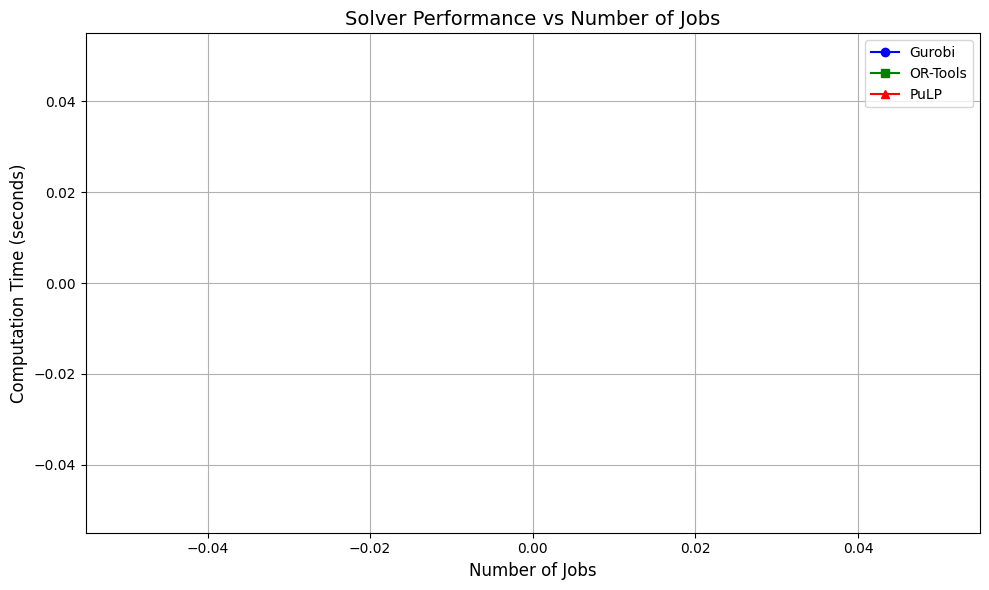

In [20]:
# Parameters
min_jobs = 25
max_jobs = 500
step = 25
n_machines = 15

# Run the solvers and get the times
job_sizes, gurobi_times, ortools_times, pulp_times = run_solver_for_varying_jobs(min_jobs, max_jobs, step, n_machines)

# Plotting the results
plt.figure(figsize=(10, 6))

plt.plot(job_sizes, gurobi_times, label='Gurobi', marker='o', linestyle='-', color='b')
plt.plot(job_sizes, ortools_times, label='OR-Tools', marker='s', linestyle='-', color='g')
plt.plot(job_sizes, pulp_times, label='PuLP', marker='^', linestyle='-', color='r')

plt.xlabel('Number of Jobs', fontsize=12)
plt.ylabel('Computation Time (seconds)', fontsize=12)
plt.title('Solver Performance vs Number of Jobs', fontsize=14)
plt.legend()

plt.grid(True)
plt.tight_layout()

plt.show()

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 349 rows, 641 columns and 1869 nonzeros
Model fingerprint: 0x07946baa
Variable types: 41 continuous, 600 integer (600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 349 rows and 641 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 2 available processors)

Solution count 1: 97 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.700000000000e+01, best bound 9.700000000000e+01, gap 0.0000%
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU 

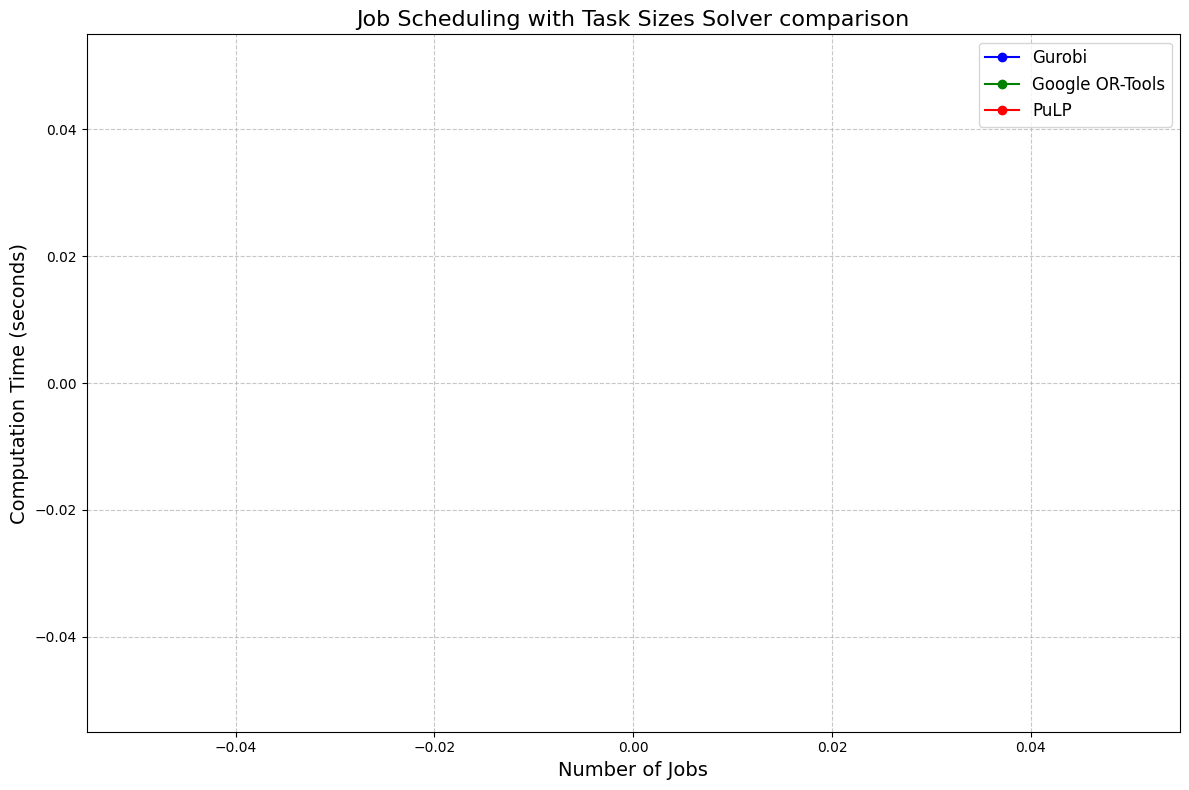

In [23]:
# Parameters
min_jobs = 20
max_jobs = 65
step = 5
n_machines = 15

# Run the solvers and get the times
job_sizes, gurobi_times, ortools_times, pulp_times = run_solver_for_varying_jobs(min_jobs, max_jobs, step, n_machines)

# Plotting the results
plt.figure(figsize=(12, 8))

plt.plot(job_sizes, gurobi_times, label='Gurobi', marker='o', linestyle='-', color='b')
plt.plot(job_sizes, ortools_times, label='Google OR-Tools', marker='o', linestyle='-', color='g')
plt.plot(job_sizes, pulp_times, label='PuLP', marker='o', linestyle='-', color='r')

plt.xlabel('Number of Jobs', fontsize=14)
plt.ylabel('Computation Time (seconds)', fontsize=14)
plt.title('Job Scheduling with Task Sizes Solver comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()